## 各種ライブラリをインポート

In [32]:
import numpy as np
# from keras import backend as K
import matplotlib.pyplot as plt
%matplotlib inline
import random
import math

In [33]:
# データをロード
training_acc = np.array(np.loadtxt('data/training_acc.txt', dtype='float32'))
training_dis = np.array(np.loadtxt('data/training_dis.txt', dtype='float32'))

print(training_acc.shape)
print(training_acc)
print(training_dis.shape)
print(training_dis)

(12, 90)
[[-0.045 -0.045 -0.045 ... -0.045  0.     0.   ]
 [ 0.    -0.045  0.    ... -0.045 -0.045  0.   ]
 [-0.045 -0.178  0.    ... -0.134 -0.401 -0.579]
 ...
 [ 0.535 -5.835  0.089 ... -0.089  0.535 -0.713]
 [-0.445  0.624 -0.089 ... -2.762  1.158 -1.203]
 [-1.425  1.025 -0.49  ... -0.935  0.579  0.089]]
(12,)
[0. 2. 1. 1. 2. 0. 2. 3. 0. 1. 2. 0.]


## 活性化関数の定義
### sigmoid, softmax, tanh関数とそれらの微分を宣言している。

In [34]:
# sigmoid function
def sigmoid(x):
    return 1/ (1 + np.exp(-x))

# derivative of sigmoid function
def sigmoid_prime(x):
    return sigmoid(x) * (1 - sigmoid(x))

# softmax function
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=0)

# derivative of softmax function
def softmax_prime(x):
    return softmax(x) * (1 - softmax(x))

# tanh function
def tanh(x):
  return (np.exp(x)-np.exp(-x)) / (np.exp(x)+np.exp(-x))

def tanh_prime(x):
  return 4 / (np.exp(x)+np.exp(-x))**2

## Layerの定義
### 初期層、中間層、出力層でクラスが分けられているが全てにおいて、<br>layer = *_layer(入力次元数, 出力次元数, 学習率（指定しないと0.03）)のように宣言する。<br>逆伝播、順伝播の場合はそれぞれlayer.forward(...)、layer.backward(...)のようにする。

In [35]:
######################################最初の層についてのクラス###########################################
class start_layer(object):
    # initation
    def  __init__(self, input_dim, output_dim, learning_rate=0.03):
        self.input_dim = input_dim # 入力次元
        self.output_dim = output_dim #出力次元
        self.learning_rate = learning_rate #学習率(0.005 ~ 0.1)
        self.weight = np.random.normal(np.sqrt(1.0/input_dim), size=(output_dim, input_dim)).astype(np.float32) #重みを決定
        self.bias = np.zeros((1, output_dim), dtype=np.float32) #バイアス項
        
    # 順伝播
    def forward(self,x):
        # x_h ... input_dim次元の(縦)ベクトル
        self.input_x = np.array(x).reshape(self.input_dim)
        
        # u_i ... output_dim次元の(縦)ベクトルを出力
        self.output_u = (np.dot(self.weight, self.input_x)).reshape(self.output_dim) 
        
        # x_i ... output_dim次元の(縦)ベクトルを出力 (tanhを作用させる)
        self.output_x = tanh(self.output_u).reshape(self.output_dim)
        
        # u_i が 出力
        return self.output_u
    
    # 逆伝播
    def backward(self,delta):# delta = δ_i
        # W = W - η .* (δ_i * x_h.T) ... (output_dim　×　nput_dim)次元の配列
        self.weight = self.weight - self.learning_rate * np.dot(delta.reshape(self.output_dim,1), self.input_x.reshape(1, self.input_dim))
        return
 #################################################################################################


######################################  中間層についてのクラス  ###########################################
class mid_layer(object):
    # initation
    def  __init__(self, input_dim, output_dim, learning_rate=0.03):
        self.input_dim = input_dim # 入力次元
        self.output_dim = output_dim #出力次元
        self.learning_rate = learning_rate #学習率(0.005 ~ 0.1)
        self.weight = np.random.normal(np.sqrt(1.0/input_dim), size=(output_dim, input_dim)).astype(np.float32) #重みを決定
        self.bias = np.zeros((1, output_dim), dtype=np.float32) #バイアス項
        
    # 順伝播   
    def forward(self,u):# u = u_i
        
        # u_i ... input_dim次元の(縦)ベクトル
        self.input_u = np.array(u).reshape(self.input_dim)
        
        # x_i ... input_dim次元の(縦)ベクトル
        self.input_x = tanh(self.input_u).reshape(self.input_dim) 
        
        # u_j ... output_dim次元の(縦)ベクトルを出力
        self.output_u = (np.dot(self.weight, self.input_x)).reshape(self.output_dim)
        
        # x_j ... output_dim次元の(縦)ベクトルを出力
        self.output_x = tanh(self.output_u).reshape(self.output_dim)
        
        # u_j が 出力
        return self.output_u
    
    # 逆伝播
    def backward(self, delta):# delta = δ_j
        
        # W = W - η .* (δ_j * x_i.T) ... (output_dim　×　nput_dim)次元の配列
        self.weight = self.weight - self.learning_rate * np.dot(delta.reshape(self.output_dim,1), self.input_x.reshape(1, self.input_dim))
        
        # δ_i = (W_ji.T *  δ_j) .* f'(u_i) ... input_dim次元の(縦)ベクトル
        return (np.dot(self.weight.T, delta) * tanh_prime(self.input_u)).reshape(self.input_dim)
#################################################################################################

    
######################################  中間層についてのクラス  ###########################################    
class last_layer(object):
    
    def  __init__(self, input_dim, output_dim, learning_rate=0.03):
        self.input_dim = input_dim # 入力次元
        self.output_dim = output_dim#出力次元
        self.learning_rate = learning_rate #学習率(0.005 ~ 0.1)
        self.weight = np.random.normal(np.sqrt(1.0/input_dim), size=(output_dim, input_dim)).astype(np.float32) #重みを決定
        self.bias = np.zeros((1, output_dim), dtype=np.float32) #バイアス項
        
    # 順伝播    
    def forward(self,u):# u = u_j
        
        # u_j ... input_dim次元の(縦)ベクトル
        self.input_u = np.array(u).reshape(self.input_dim) 
        
        # x_j ... input_dim次元の(縦)ベクトル
        self.input_x = tanh(self.input_u).reshape(self.input_dim)
        
        # u_k ... output_dim次元の(縦)ベクトルを出力
        self.output_u = (np.dot(self.weight, self.input_x)).reshape(self.output_dim)
        
        # x_k ... output_dim次元の(縦)ベクトルを出力
        self.output_x = tanh(self.output_u).reshape(self.output_dim)
        
        # x_k が最終結果
        return self.output_x
    
    # 逆伝播
    def backward(self,loss):# loss = y - y^p
        
        # δ_k = loss * f'(u_k) ... output_dim次元の(縦)ベクトルを出力
        self.delta = (loss * tanh_prime(self.output_u)).reshape(self.output_dim)
        
        # W = W - η .* (δ_k * x_j.T) ... (output_dim　×　nput_dim)次元の配列
        self.weight = self.weight - self.learning_rate * np.dot(self.delta.reshape(self.output_dim,1), self.input_x.reshape(1,self.input_dim))
        #print("gradient = {}".format(np.dot(self.delta.reshape(self.output_dim,1), self.input_x.reshape(1,self.input_dim))))
        
        #  δ_j = (W_kj.T *  δ_k) .* f'(u_j) ... input_dim次元の(縦)ベクトル
        return ( np.dot(self.weight.T, self.delta) * tanh_prime(self.input_u) ).reshape(self.input_dim)
#################################################################################################

## 3層用ニューラルネットの定義

In [36]:
def nn_3(first_layer=90, second_layer=60, third_layer=1, learning_rate=0.005, epoch_number=200, train_number=500, test_number = 100):
    lay_1 = start_layer(first_layer, second_layer, learning_rate)
    lay_2 = last_layer(second_layer, third_layer, learning_rate)

    np.set_printoptions(precision=3)
    accuracy_list = []
    epoch_list = []
    loop = 0
    epoch_number = epoch_number#200
    train_number = train_number#500
    test_number = test_number#100

    for epoch in range(0,epoch_number): 
        for i in range(0,train_number):
            random_train_index = random.randint(0,training_acc.shape[0]-1)
            #順伝播
            output = lay_1.forward(training_acc[random_train_index].reshape(first_layer))
            output = lay_2.forward(output)

            #逆伝播
            correct_answer = training_dis[random_train_index]
            loss = output - correct_answer/5
            delta = lay_2.backward(loss)
            delta = lay_1.backward(delta)

        #テストデータで正答率をチェック
        count = 0
        for j in range(0,test_number):
            random_test_index = random.randint(0,training_acc.shape[0]-1)
            output = lay_1.forward(training_acc[random_test_index].reshape(first_layer))
            output = lay_2.forward(output)
    
            #print("output = {}".format(output))
            #print("prediction = {} <---> test_labels = {}.".format(np.argmax(output), test_labels[random_test_index]))

            count += int(training_dis[random_test_index] - 5 * output)

        loop += 1
        #print("#",end="")
        print("\t{:2.0f} / {} finished.  accuracy = {:2.5f}".format(loop, epoch_number, count/test_number))
        epoch_list.append(epoch)
        accuracy_list.append(count/test_number)

    print("\t finished")
    return epoch_list, accuracy_list, lay_1, lay_2

In [37]:
epoch, step_diff, lay1, lay2= nn_3()

	 1 / 200 finished.  accuracy = -0.46000
	 2 / 200 finished.  accuracy = -0.84000
	 3 / 200 finished.  accuracy = -0.43000
	 4 / 200 finished.  accuracy = -1.09000
	 5 / 200 finished.  accuracy = -0.74000
	 6 / 200 finished.  accuracy = -1.34000
	 7 / 200 finished.  accuracy = -0.46000
	 8 / 200 finished.  accuracy = -0.14000
	 9 / 200 finished.  accuracy = -0.29000
	10 / 200 finished.  accuracy = -0.12000
	11 / 200 finished.  accuracy = -0.32000
	12 / 200 finished.  accuracy = -0.58000
	13 / 200 finished.  accuracy = -0.15000
	14 / 200 finished.  accuracy = -0.39000
	15 / 200 finished.  accuracy = -0.33000
	16 / 200 finished.  accuracy = -0.94000
	17 / 200 finished.  accuracy = 0.06000
	18 / 200 finished.  accuracy = -0.27000
	19 / 200 finished.  accuracy = -0.28000
	20 / 200 finished.  accuracy = -0.72000
	21 / 200 finished.  accuracy = 0.09000
	22 / 200 finished.  accuracy = -0.32000
	23 / 200 finished.  accuracy = -0.17000
	24 / 200 finished.  accuracy = -0.11000
	25 / 200 finished

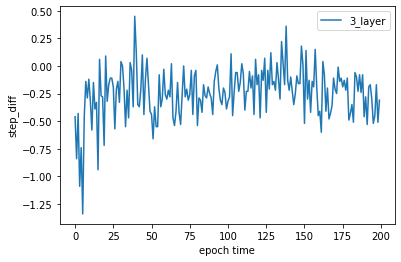

In [38]:
plt.plot(epoch, step_diff,label="3_layer")

plt.xlabel("epoch time")
plt.ylabel("step_diff")
plt.legend()
plt.show()
#plt.savefig("../report/5-2-1.png")

In [39]:
#保存
np.savetxt("data/w1.txt",lay1.weight, delimiter=' ', fmt='%f')
np.savetxt("data/w2.txt",lay2.weight, delimiter=' ', fmt='%f')

In [45]:
w = np.array(np.loadtxt('data/w1.txt', dtype='float32'))

print("w = \n", w)
print("\nlay1.weight = \n",lay1.weight)
print("\nw == lay.weight ?\n",w==lay1.weight)

if np.all(w==lay1.weight):
  print("\nYEAH")
else:
  print("\nOh, my Gosh")

w = 
 [[-1.211  2.091  0.388 ... -0.976  0.999  0.155]
 [ 0.204  1.261 -1.09  ... -1.713  1.606 -0.003]
 [-0.393  0.231  0.971 ...  0.206 -0.187  1.565]
 ...
 [-0.518  0.503  0.643 ...  1.523 -0.588  1.239]
 [ 1.136  1.296  0.279 ...  0.749  0.317 -0.033]
 [ 0.008  0.762 -1.334 ...  1.343 -0.311 -0.728]]

lay1.weight = 
 [[-1.211  2.091  0.388 ... -0.976  0.999  0.155]
 [ 0.204  1.261 -1.09  ... -1.713  1.606 -0.003]
 [-0.393  0.231  0.971 ...  0.206 -0.187  1.565]
 ...
 [-0.518  0.503  0.643 ...  1.523 -0.588  1.239]
 [ 1.136  1.296  0.279 ...  0.749  0.317 -0.033]
 [ 0.008  0.762 -1.334 ...  1.343 -0.311 -0.728]]

w == lay.weight ?
 [[False  True False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]

Oh, my Gosh


In [48]:
acc_array = np.zeros(90)
output = lay1.forward(acc_array.reshape(90))
output = lay2.forward(output)
print("output = ",float(output))

output =  0.0
